In [ ]:
# Instalação das bibliotecas
!pip install requests pandas duckdb matplotlib

In [48]:
import json
import requests
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

# Função para consumir os dados da API SWAPI e salvar como JSON
def get_data_and_save(endpoint, filename):
    url = f"https://swapi.dev/api/{endpoint}/"
    data = []
    while url:
        response = requests.get(url)
        if response.status_code == 200:
            json_data = response.json()
            data.extend(json_data['results'])
            url = json_data['next']
        else:
            print(f"Erro ao buscar {endpoint}")
            break
# Salvando os dados em arquivo JSON
    with open(filename, 'w') as file:
        json.dump(data, file)
    print(f"Dados salvos em {filename}")
    return data

# Baixando e salvando os dados em arquivos JSON
characters = get_data_and_save('people', 'personagens.json')
planets = get_data_and_save('planets', 'planets.json')
starships = get_data_and_save('starships', 'starships.json')
films = get_data_and_save('films', 'films.json')

Dados salvos em personagens.json
Dados salvos em planets.json
Dados salvos em starships.json
Dados salvos em films.json


In [64]:
#Criar banco de dados com json no duckdb
import duckdb
con = duckdb.connect("starwars.db")

con.execute("CREATE TABLE IF NOT EXISTS personagens AS SELECT * FROM read_json_auto('personagens.json')")

con.execute("CREATE TABLE IF NOT EXISTS planets AS SELECT * FROM read_json_auto('planets.json')")
con.execute("CREATE TABLE IF NOT EXISTS starships AS SELECT * FROM read_json_auto('starships.json')")
con.execute("CREATE TABLE IF NOT EXISTS films AS SELECT * FROM read_json_auto('films.json')")


Analise dos dados para responder às perguntas usando consultas SQL.

In [35]:

# Qual é o personagem que apareceu em mais filmes de Star Wars?
query1 = '''
-- Step 1: Unnest de filmes para cada personagem
WITH unnest AS (
    SELECT
        p.name ,
        UNNEST(films) AS films
    FROM
        personagens p
)

-- Step 2: Contagem de filmes por personagem

    SELECT name as Personagem, 
    COUNT(films) as 'Total de filmes'
FROM unnest 
GROUP BY name 
ORDER BY 2 DESC 
LIMIT 1
;
'''

result_1 = con.execute(query1).fetchdf()
print("Personagem que apareceu em mais filmes de Star Wars:")
# sem o index
print(result_1.to_string(index=False))


Personagem que apareceu em mais filmes de Star Wars:
Personagem  Total de filmes
     C-3PO                6


In [47]:
# Quais são os planetas mais quentes do universo de Star Wars? (filtrando por climas quentes)
query2 = '''
SELECT name, climate 
FROM planets 
WHERE climate LIKE '%hot%' OR climate LIKE '%warm%'
'''
result_2 = con.execute(query2).fetchdf()
print("Planetas mais quentes:")
print(result_2.to_string(index=False))

Planetas mais quentes:
     name    climate
 Mustafar        hot
  Felucia hot, humid
Saleucami        hot
    Rodia        hot


In [67]:
#Quais são as naves espaciais mais rápida do universo de Star Wars?
query3 = '''
SELECT name, TRY_CAST(REGEXP_REPLACE(max_atmosphering_speed, '[^0-9]', '', 'g') AS INTEGER) AS max_speed
FROM starships 
WHERE max_atmosphering_speed != 'n/a'
ORDER BY max_speed DESC
LIMIT 5
'''
result_3 = con.execute(query3).fetchdf()
print("As naves espaciais mais rápida:")
print(result_3.to_string(index=False))


As naves espaciais mais rápida:
                    name  max_speed
     H-type Nubian yacht       8000
 J-type diplomatic barge       2000
Theta-class T-2c shuttle       2000
            Solar Sailer       1600
        Jedi Interceptor       1500


In [103]:
# Consultando qual é a arma mais poderosa do universo de Star Wars 
query4 = '''
SELECT name, starship_class,cargo_capacity
FROM 
(
    SELECT name, model, starship_class, CAST(cargo_capacity AS BIGINT) AS cargo_capacity
    FROM starships
    WHERE cargo_capacity != 'unknown'  -- Excluindo entradas desconhecidas
)
ORDER BY cargo_capacity DESC
LIMIT 1
'''

result_4 = con.execute(query4).fetchdf()
print("A nave mais poderosa:")
print(result_4.to_string(index=False))

A nave mais poderosa:
      name                  starship_class  cargo_capacity
Death Star Deep Space Mobile Battlestation   1000000000000


Quantidade de personagens por gênero:
       gender  count
         male     60
       female     17
hermaphrodite      1


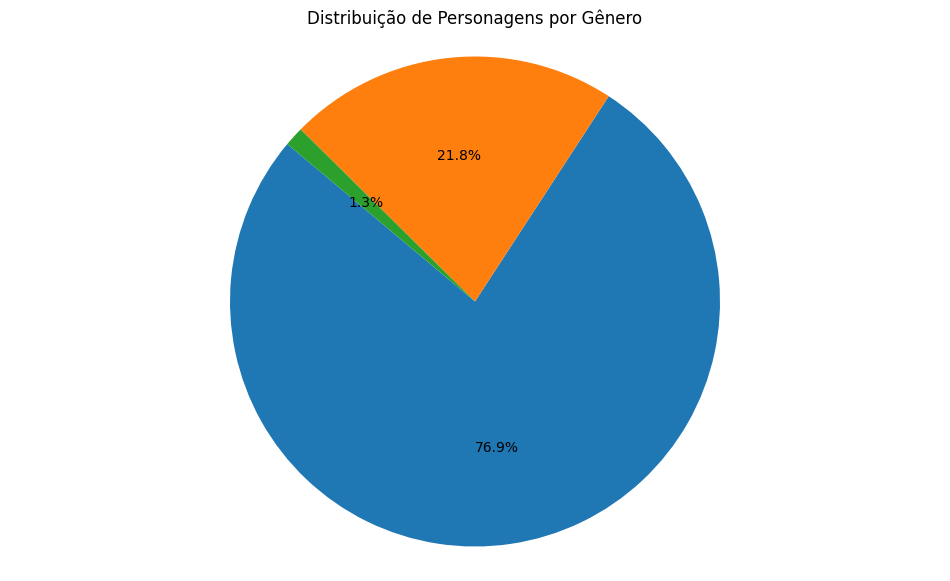

In [112]:
# retorne a quantidade de personagens por gênero 
query = """SELECT 
    gender,
    COUNT(*) AS count
FROM 
    personagens
WHERE gender not in ('n/a', 'none')
GROUP BY 
    gender; """
result_5 = con.execute(query).fetchdf()
print("Quantidade de personagens por gênero:")
print(result_5.to_string(index=False))

#fecha conexão
con.close()

# Criando um gráfico de pizza
plt.figure(figsize=(12, 7))
plt.pie(result_5['count'], autopct='%1.1f%%', startangle=140)

# Adicionando um título ao gráfico
plt.title('Distribuição de Personagens por Gênero')
# Adicionando uma legenda
plt.legend
plt.axis('equal')
plt.show()
